# Testing GalFlow convolutions against GalSim

In [1]:
%pylab inline
import galsim

Populating the interactive namespace from numpy and matplotlib


## Step 1: Get some input images from GalSim

In [2]:
cat = galsim.COSMOSCatalog()
gal = cat.makeGalaxy(2,  gal_type='real', noise_pad_size=0)

In [3]:
psf = galsim.Gaussian(0.07)

In [4]:
# Checking psf and gal image scales
pixel_scale=0.03

In [5]:
# We draw the PSF image in Kspace at the correct resolution
N = 110
im_scale = 0.03
interp_factor=2
padding_factor=4
Nk = N*interp_factor*padding_factor
from galsim.bounds import _BoundsI

In [6]:
import tensorflow as tf
import galflow as gf

In [7]:
bounds = _BoundsI(-Nk//2, Nk//2-1, -Nk//2, Nk//2-1)

impsf = psf.drawKImage(bounds=bounds,
                       scale=2.*np.pi/(N*padding_factor* im_scale))

imgal = gal.drawKImage(bounds=bounds,
                       scale=2.*np.pi/(N*padding_factor* im_scale))

In [8]:
kgal = galsim.InterpolatedKImage(imgal, k_interpolant='linear')
kpsf = galsim.InterpolatedKImage(impsf, k_interpolant='linear')

<ipython-input-9-44160134c41c>:1: RuntimeWarning: divide by zero encountered in log10
  imshow(log10(abs(imgal.array)), cmap='gist_stern',vmin=-10);colorbar()


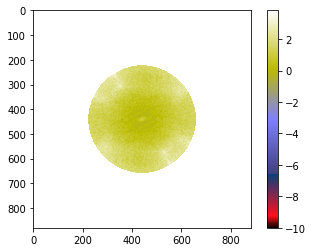

In [9]:
imshow(log10(abs(imgal.array)), cmap='gist_stern',vmin=-10);colorbar()

In [10]:
tfimpsf = tf.convert_to_tensor(impsf.array, dtype=tf.complex64)
tfimgal = tf.convert_to_tensor(imgal.array, dtype=tf.complex64)

In [11]:
tfimpsf = tf.reshape(tfimpsf, shape=[1, 110*interp_factor*padding_factor, 110*interp_factor*padding_factor, 1])
tfimgal = tf.reshape(tfimgal, shape=[1, 110*interp_factor*padding_factor, 110*interp_factor*padding_factor, 1])

In [12]:
import galflow as gf

In [13]:
sheared_tfimgal= gf.shear(tfimgal, g1=0.3*tf.ones(1), g2=0.2*tf.ones(1))# tf.complex(a,b )

In [14]:
# convolve with image
tfconv = sheared_tfimgal*tfimpsf

In [15]:
sheared_kgal = kgal.shear(g1=0.3, g2=0.2)
sheared_kgal = galsim.Convolve(sheared_kgal, kpsf)
bounds = _BoundsI(-Nk//2, Nk//2-1, -Nk//2, Nk//2-1)

k_imkref = sheared_kgal.drawKImage(bounds=bounds,
                          scale=2.*np.pi/(N*padding_factor* im_scale))

<ipython-input-16-8c5a6217071f>:3: RuntimeWarning: divide by zero encountered in log10
  imshow(log10(abs(k_imkref.array)), cmap='gist_stern',vmax=1);colorbar()
<ipython-input-16-8c5a6217071f>:6: RuntimeWarning: divide by zero encountered in log10
  imshow(log10(abs(tfconv[0,:,:,0])), cmap='gist_stern',vmax=1);colorbar()
<ipython-input-16-8c5a6217071f>:9: RuntimeWarning: divide by zero encountered in log10
  imshow(log10(abs(tfconv[0,:,:,0].numpy() - k_imkref.array)), cmap='gist_stern');colorbar()


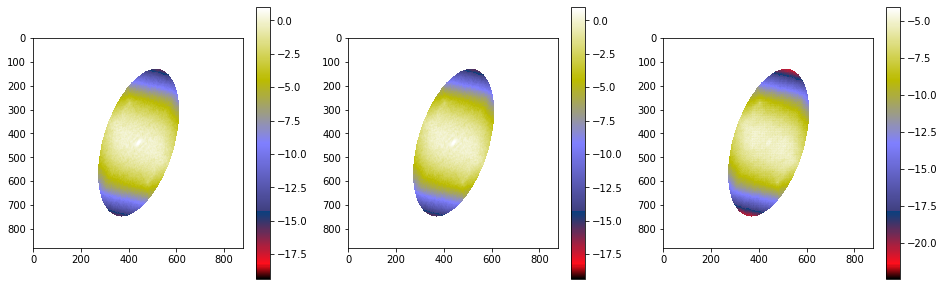

In [16]:
figure(figsize=[16,5])
subplot(131)
imshow(log10(abs(k_imkref.array)), cmap='gist_stern',vmax=1);colorbar()

subplot(132)
imshow(log10(abs(tfconv[0,:,:,0])), cmap='gist_stern',vmax=1);colorbar()

subplot(133)
imshow(log10(abs(tfconv[0,:,:,0].numpy() - k_imkref.array)), cmap='gist_stern');colorbar()

In [17]:
tfconv.shape

TensorShape([1, 880, 880, 1])

In [18]:
tfconv.dtype

tf.complex64

In [19]:
# Removing negative frequencies
rtfconv = tf.signal.fftshift(tfconv,axes=2)[:,:,:880//2+1,0]

In [20]:
# # Apply kwrapping
# def k_wrapping(kimage, wrap_factor=2):
#   """
#   Wraps kspace image of a real image to decrease its resolution by specified
#   factor
#   """
#   batch_size, Nkx, Nky = kimage.get_shape().as_list()

#   # First wrap around the non hermitian dimension
#   rkimage = kimage + tf.roll(kimage, shift=-Nkx//wrap_factor, axis=1)+ tf.roll(kimage, shift=Nkx//wrap_factor, axis=1)

#   # Now take care of the hermitian part
#   revrkimage = tf.roll(tf.reverse(tf.math.conj(tf.reverse(rkimage, axis=[2])), axis=[1]),  shift=-Nkx//wrap_factor, axis=2)
  
#   # These masks take care of the special case of the 0th frequency
#   mask = np.ones((1, Nkx, Nky))
#   mask[:,0,:]=0
#   mask[:,Nkx//wrap_factor-1,:]=0
#   rkimage2 = rkimage + revrkimage*mask
#   mask = np.zeros((1, Nkx, Nky))
#   mask[:,Nkx//wrap_factor-1,:]=1
#   rkimage2 = rkimage2 + tf.roll(revrkimage,shift=-1, axis=1) *mask

#   # Now that we have wrapped the image, we can truncate it to the desired size
#   kimage = tf.signal.fftshift(rkimage2, axes=1)[:, :Nkx//wrap_factor, :(Nky-1)//wrap_factor+1]

#   return kimage

def k_wrapping(kimage, wrap_factor=2):
  """
  Wraps kspace image of a real image to decrease its resolution by specified
  factor
  """
  batch_size, Nkx, Nky = kimage.get_shape().as_list()

  # First wrap around the non hermitian dimension
  rkimage = kimage + tf.roll(kimage, shift=Nkx//wrap_factor, axis=1)

  # Now take care of the hermitian part
  revrkimage = tf.reverse(tf.math.conj(tf.reverse(rkimage, axis=[2])), axis=[1])

  # These masks take care of the special case of the 0th frequency
  mask = np.ones((1, Nkx, Nky))
  mask[:,0,:]=0
  mask[:,Nkx//wrap_factor-1,:]=0
  rkimage2 = rkimage + revrkimage*mask
  mask = np.zeros((1, Nkx, Nky))
  mask[:,Nkx//wrap_factor-1,:]=1
  rkimage2 = rkimage2 + tf.roll(revrkimage,shift=-1, axis=1) *mask

  # Now that we have wrapped the image, we can truncate it to the desired size
  kimage = rkimage2[:, :Nkx//wrap_factor, :(Nky-1)//wrap_factor+1]

  return kimage

In [21]:
rtfconv = k_wrapping(rtfconv, wrap_factor=2)

<ipython-input-22-31cbac07e6f7>:1: RuntimeWarning: divide by zero encountered in log10
  imshow(log10(abs(rtfconv[0,:,:])), cmap='gist_stern',vmin=-10);colorbar()


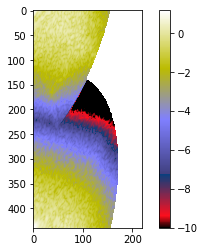

In [22]:
imshow(log10(abs(rtfconv[0,:,:])), cmap='gist_stern',vmin=-10);colorbar()

In [23]:
# Ifft
conv_images = tf.expand_dims(tf.signal.fftshift(tf.signal.irfft2d(rtfconv)),-1)
# removing padding
conv_images = tf.image.resize_with_crop_or_pad(conv_images, 110, 110)

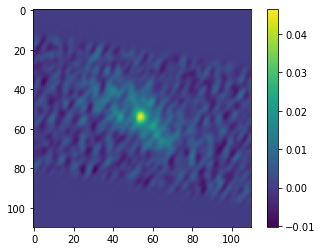

In [24]:
imshow((((conv_images[0,:,:].numpy())))); colorbar()

In [28]:
# Same thing with GalSim
#sheared_gal = gal.original_gal
sheared_gal = gal.shear(g1=0.3, g2=0.2)
sheared_gal = galsim.Convolve(sheared_gal, psf)

im_ref = sheared_gal.drawImage(nx=110, ny=110, scale=0.03,
                               method='no_pixel',use_true_center=False).array

In [29]:
sheared_kgal = kgal.shear(g1=0.3, g2=0.2)
sheared_kgal = galsim.Convolve(sheared_kgal, kpsf)

im_kref = sheared_kgal.drawImage(nx=110, ny=110, scale=0.03,
                               method='no_pixel',use_true_center=False).array

In [30]:
bounds = _BoundsI(-Nk//2, Nk//2-1, -Nk//2, Nk//2-1)

k_imkref = sheared_kgal.drawKImage(bounds=bounds,
                          scale=2.*np.pi/(N*padding_factor*im_scale),
                          recenter=False)

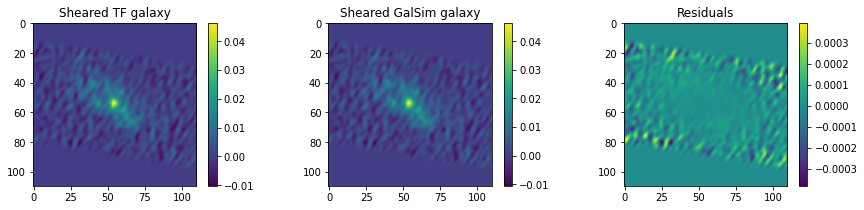

In [31]:
figure(figsize=[15,3])
subplot(131)
title('Sheared TF galaxy')
imshow(((conv_images[0,:,:].numpy().real)))
colorbar();
subplot(132)
title('Sheared GalSim galaxy')
imshow(im_ref)
colorbar();
subplot(133)
title('Residuals')
imshow(im_ref - conv_images[0,:,:,0].numpy().real);
colorbar();

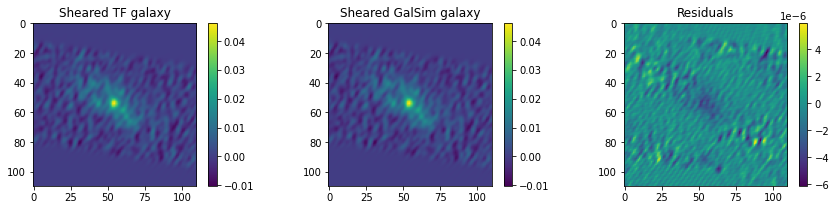

In [32]:
# This plot is using the same interpolation order in both TF and GalSim
figure(figsize=[15,3])
subplot(131)
title('Sheared TF galaxy')
imshow(((conv_images[0,:,:].numpy().real)))
colorbar();
subplot(132)
title('Sheared GalSim galaxy')
imshow(im_kref)
colorbar();
subplot(133)
title('Residuals')
imshow(im_kref - conv_images[0,:,:,0].numpy());
colorbar();